# Traveling Salesman Problem
The Traveling Salesman Problem (TSP) concerns finding the shortest path that a traveling salesman can take to go through a list of cities in the shortest time possible. This problem is represented in a graph $G =(V,E)$. Each vertex in the graph $G$ represents a different camp, while the weights on each of the edges $(u,v)$ represent the distance between the two camps $u$ and $v$. 

This is an NP-Hard problem, and there is no known classical algorithm that is know to solve this problem in linear time. 


# Installing Dependencies

In [2]:
# installing necessary modules
! pip install networkx --upgrade
! pip install qibo 

Requirement already up-to-date: networkx in /opt/anaconda3/lib/python3.8/site-packages (3.1)


# Introductory Challenge  

The initial task in this challenge requires you to determine a Hamiltonian that can effectively solve the Traveling Salesman Problem (TSP). 
To achieve this, a set of functions has been provided for you to complete, enabling you to find the solution using both Quantum Alternating Operator Ansatz (QAOA) and Adiabatic Quantum Optimization (AQO).

To solve this challenge, you will need to accomplish the following tasks:
1. Construct the cost, mixer, and initial Symbolic Hamiltonians that will be used for QAOA and AQO.
2. Prepare a suitable initial state for the system.
3. print and visualize your results. 
4. calculate the Fidelity of your results for both QAOA and AQO. 

## Graph construction

We first have to define the different camps and distances using a graph. Here you can find the definition of these camps:

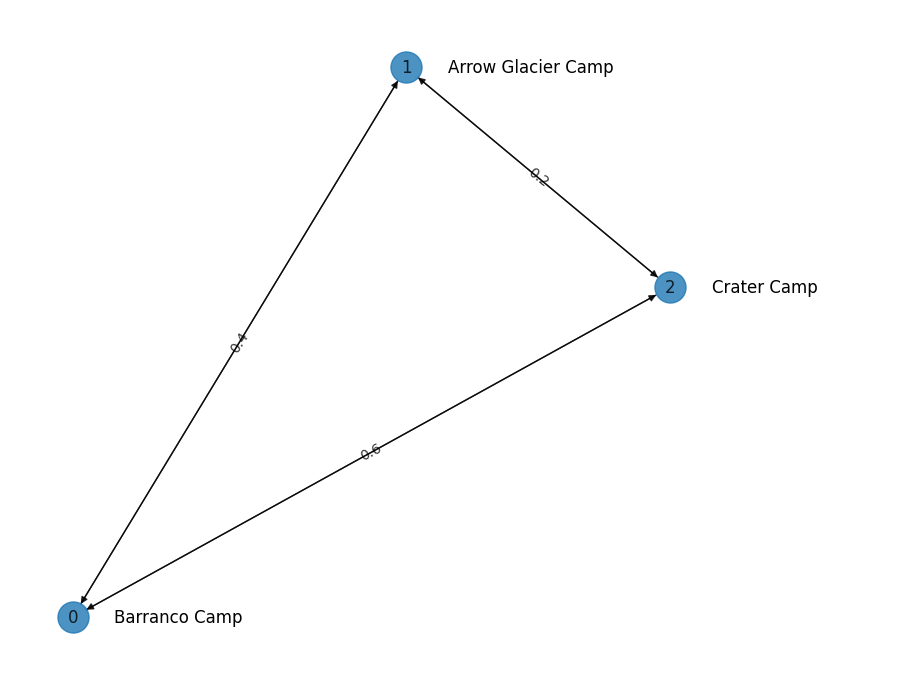

'\nfor i, j in G.edges:\n    print(i, j, G[i][j]["weight"])\n'

In [177]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.4)
G.add_edge(1, 0, weight=0.4)

G.add_edge(0, 2, weight=0.6)
G.add_edge(2, 0, weight=0.6)

G.add_edge(1, 2, weight=0.2)
G.add_edge(2, 1, weight=0.2)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

# creating node labels
labels = {}
labels[0] = 'Barranco Camp'
labels[1] = 'Arrow Glacier Camp'
labels[2] = 'Crater Camp'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()

lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()

'''
for i, j in G.edges:
    print(i, j, G[i][j]["weight"])
'''

In [178]:
G.get_edge_data(0,1,default = 0.7)

{'weight': 0.4}

## Solution 

In [206]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''
    constraint_weight = 2

    def A(i,j):
        return 1/2*(1-Z(3*j+i))

    # total distance travelled
    sham_1 = sum(sum(G.get_edge_data(i,j,default={'weight': 1.2})['weight'] * sum(A(i,t)*A(j,t+1) for t in (0,1)) for i in (0,1,2))for j in (0,1,2))

    # constraints due to not 
    sham_2 = sum((1 - sum(A(i,t) for i in (0,1,2)))**2 for t in range(G.number_of_nodes()))

    # constraint due to not
    sham_3 = sum((1 - sum(A(i,t) for t in range(G.number_of_nodes())))**2 for i in range(G.number_of_nodes()))

    #Hamiltonians
    H_1 = hamiltonians.SymbolicHamiltonian(sham_1)
    H_2 = hamiltonians.SymbolicHamiltonian(sham_2)
    H_3 = hamiltonians.SymbolicHamiltonian(sham_3)
    return H_1 + constraint_weight * (H_2 + H_3)

In [180]:

def s_plus(i):
    return X(i) + 1j * Y(i)

def s_minus(i):
    return X(i) - 1j * Y(i)
    
def sham_ij(i,j):
    return s_plus(i) * s_plus(j) * s_minus(j) * s_minus(i) + s_minus(i) * s_minus(j) * s_plus(j) * s_plus(i)

def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''

    #sham = sum( sham_ij(i, j) for i in range(G.number_of_nodes()) for j in range(G.number_of_nodes()**2) ) 
    sham = sum((X(i)) for i in range(G.number_of_nodes()**2 ))
    return hamiltonians.SymbolicHamiltonian(sham)
    


In [181]:

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''

    sham = sum((X(i)) for i in range(G.number_of_nodes()**2 )) 
    return hamiltonians.SymbolicHamiltonian(sham)


In [182]:

def prepare_initial_state(G: nx.Graph):
    return np.ones(512)/np.sqrt(512)


In [183]:

def display_solution(state: str):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''

    # define a directed graph 
    G = nx.DiGraph()

    # define the edges of the graph with their corresponding weights
    n = int(np.sqrt(len(state)))
    Steps = np.zeros(n)
    for j in range(n):
        for i in range(n):
            if state[i+ j*n] == '1':
                Steps[j] = i
        G.add_node(j)
        if j > 0:
            G.add_edge(Steps[j-1],Steps[j])

    pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

    # creating node labels
    labels = {}
    labels[0] = 'Barranco Camp'
    labels[1] = 'Arrow Glacier Camp'
    labels[2] = 'Crater Camp'

    # applying a shift to the node labels for readability purposes 
    shift = np.array([0.03, 0])
    shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

    # draw node labels
    nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")
    #plot the graph and the edge labels
    nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

    # adjust frame to avoid cutting text, may need to adjust the value
    axis = plt.gca()

    lim = axis.get_xlim()
    axis.set_xlim([lim[0], lim[1] * 1.7])

    # increase the size of the figure
    figure_size = plt.gcf().get_size_inches()
    factor = 1.8
    plt.gcf().set_size_inches(factor * figure_size)

    plt.show() 


## Quantum Alternating Operator Ansatz (QAOA)

In [207]:
import numpy as np
from qibo import models, hamiltonians

nqubits = G.number_of_nodes() ** 2
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)
H = hamiltonian.ground_state()

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = [0.50214374, 0.28657217, 0.43289768, 0.92827525, 0.08182783, 0.13269205,
 0.95917048, 0.13331689]

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS",
    initial_state = initial_state
    )

print("best energy: ", best_energy)

[Qibo 0.1.13|WARNING|2023-05-07 10:46:05]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


number of qubits needed to solve the problem:  9
best energy:  3.6700466299283296


In [187]:
np.where(H == 1)

(array([84]),)

[('100010001', 1570), ('001100010', 1522), ('001010100', 1506), ('010001100', 1466), ('100001010', 1458), ('010100001', 1448), ('010101000', 622), ('000101010', 558), ('001110000', 514), ('000110001', 497), ('000011100', 462), ('100011000', 448), ('001100000', 328), ('000100001', 297), ('010100000', 291), ('100001000', 280), ('000001100', 271), ('000100010', 259), ('000001010', 233), ('010001000', 221), ('001010000', 214), ('100010000', 214), ('000010100', 209), ('000010001', 205), ('010101010', 205), ('001110001', 173), ('100011100', 158), ('000100000', 140), ('000001000', 113), ('000010000', 100), ('000010101', 88), ('100000001', 87), ('000000000', 81), ('000101000', 80), ('101010000', 79), ('110001000', 71), ('001000100', 69), ('011100000', 68), ('001100100', 66), ('010000100', 66), ('100100001', 66), ('100100010', 65), ('000001110', 64), ('100001100', 63), ('100000010', 62), ('010000101', 60), ('100010100', 60), ('001010001', 58), ('011100100', 57), ('000000100', 55), ('000100011',

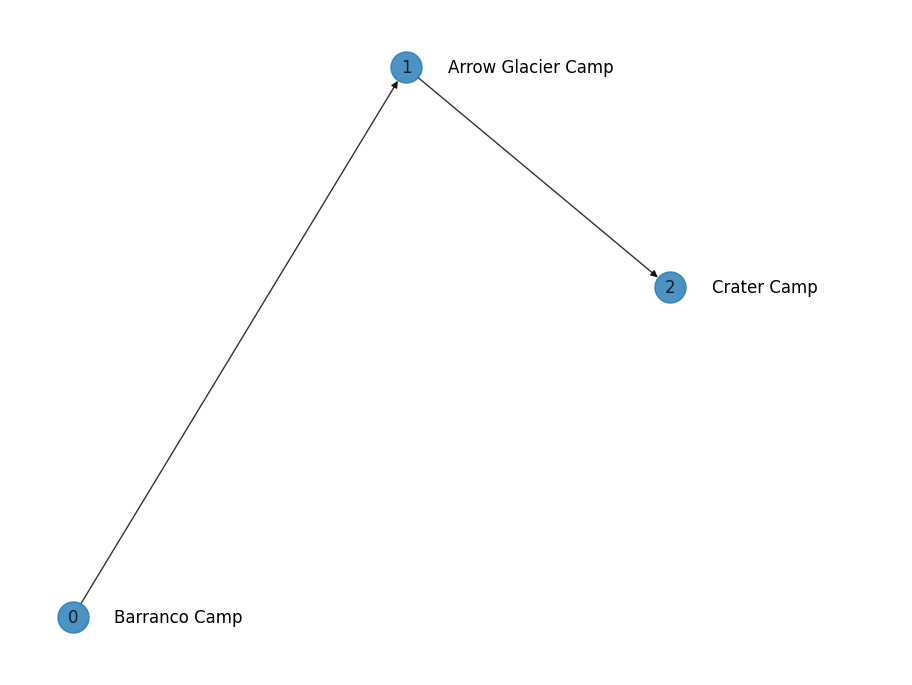

[0.50214374, 0.28657217, 0.43289768, 0.92827525, 0.08182783, 0.13269205, 0.95917048, 0.13331689]


In [211]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute()#initial_state)

# measure the output of the circuit and obtain results
nshots= 20000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
print(ordered_freq_counter)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(qaoa_solution) # QAOA solution is a binary string containing the solution 
print(initial_parameters)

## Adiabatic Quantum Optimization

In [212]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.1
nqubits = (G.number_of_nodes()) ** 2

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.matrix)
H0_dense = Hamiltonian(nqubits, H0.matrix)

# define the scheduler
def s(t): return t

T = 80

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

[Qibo 0.1.13|WARNING|2023-05-07 10:47:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-05-07 10:47:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


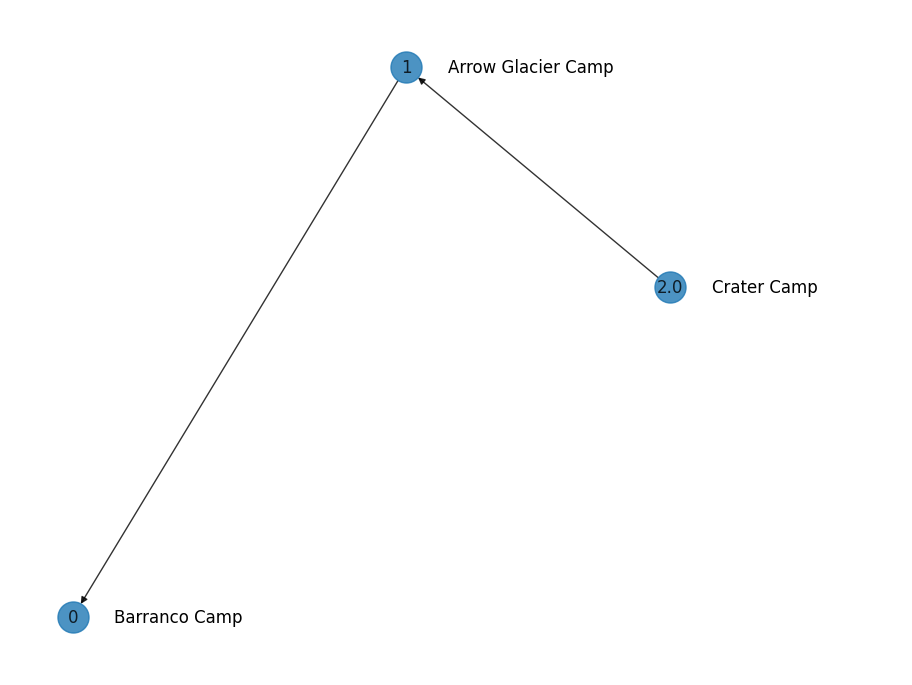

In [213]:
# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

display_solution(adiabatic_solution) # adiabatic solution is a binary string containing the solution

In [214]:
solution_array = np.argsort(np.abs(adiabatic_quantum_state) ** 2)[-20:]
print((np.abs(adiabatic_quantum_state) ** 2)[solution_dec])
for i in solution_array:
    print("{0:0{bits}b}".format(i, bits=nqubits)," ", (np.abs(adiabatic_quantum_state) ** 2)[i])

0.3686720144097867
100000010   1.7970069890202342e-05
000010100   1.9117746227680038e-05
100010000   1.9117746227690816e-05
100000001   2.7904455007625638e-05
001000100   2.790445500763074e-05
001010001   3.143458153257777e-05
000001010   3.2062759619214886e-05
010001000   3.206275961921936e-05
010000001   3.865760135608986e-05
001000010   3.86576013560979e-05
101000010   4.667579416915397e-05
010000101   4.6675794169161676e-05
001000110   4.707004304877487e-05
110000001   4.707004304879347e-05
001100010   0.019975571476503577
010100001   0.019975571476503664
010001100   0.11097949679963622
100001010   0.11097949679963817
100010001   0.3686720144097713
001010100   0.3686720144097867


# Real Life Challenges 

In this challenge, you will be tasked with solving TSP for an extended graph on a quantum computer that has a limited number of qubits. Specifically, the quantum computer will only have 6 qubits available. Moreover, the extended graph includes two new nodes a starting and ending locations. Your solution must begin at the starting point which is Karanga Camp and end at the Kibo peak.

To solve this challenge, you will need to accomplish the following tasks:

1. Design and build a new Hamiltonian that takes into account the lack of qubits and the addition of the two new nodes.
2. Calculate and analyze the fidelity of both the AQO and QAOA solutions.
3. Experiment with different scheduling strategies to improve the fidelity of your solution.

It is important that you document the steps you follow and your findings in a clear and concise manner. Good luck!

## Graph construction 

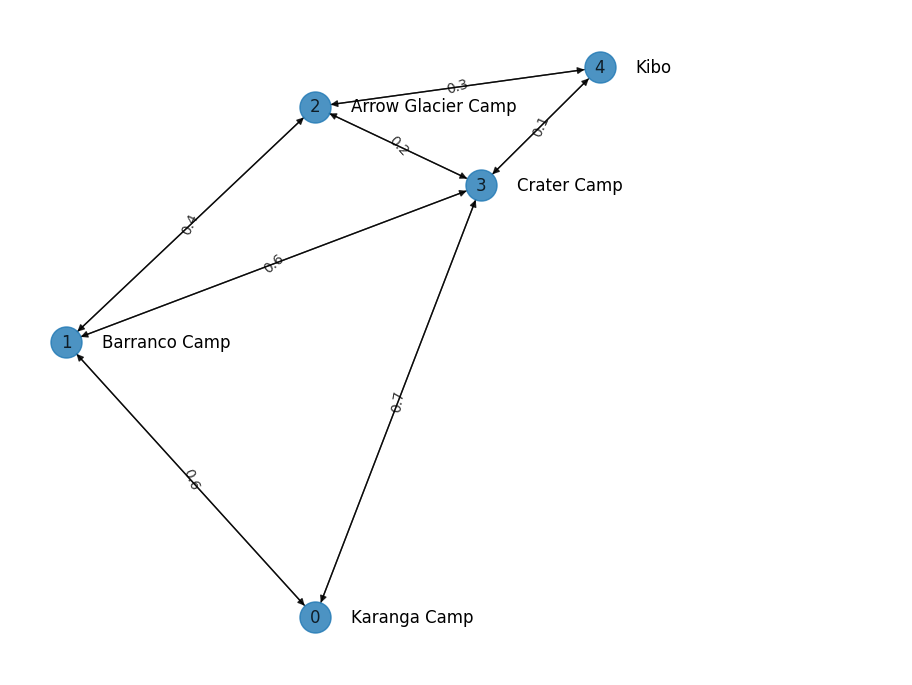

In [217]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.6)
G.add_edge(1, 0, weight=0.6)

G.add_edge(0, 3, weight=0.7)
G.add_edge(3, 0, weight=0.7)

G.add_edge(1, 3, weight=0.6)
G.add_edge(3, 1, weight=0.6)

G.add_edge(1, 2, weight=0.4)
G.add_edge(2, 1, weight=0.4)

G.add_edge(2, 3, weight=0.2)
G.add_edge(3, 2, weight=0.2)

G.add_edge(3, 4, weight=0.1)
G.add_edge(4, 3, weight=0.1)

G.add_edge(2, 4, weight=0.3)
G.add_edge(4, 2, weight=0.3)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

# creating node labels
labels = {}
labels[0] = 'Karanga Camp'
labels[1] = 'Barranco Camp'
labels[2] = 'Arrow Glacier Camp'
labels[3] = 'Crater Camp'
labels[4] = 'Kibo'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 

In [219]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''
    #weight of the constraint Hamiltonians
    constraint_weight = 1.5
    #Operators related to the x_{i,t} binary variable
    def A(i,j):
        if (i,j) == (0,0):
            return 1
        if i == 0 and j>0:
            return 0
        if j == 0 and i >0:
            return 0
        if i == 4 and j == 4:
            return 1
        if i == 4 and j < 4:
            return 0
        if i < 4 and j == 4:
            return 0
        if i == 1 and j == 1:
            return 1/2*(1 - Z(0))
        if i == 1 and j == 2:
            return 1/2*(1-Z(2))
        if i == 2 and j == 1:
            return 1/2*(1-Z(1))
        if i == 2 and j == 2:
            return 1/2*(1-Z(3))
        if i == 1 and j ==3:
            return 1 - 1/2*(2- Z(2)-Z(0))
        if i == 2 and j == 3:
            return 1 - 1/2*(2 -Z(3)-Z(1))
        if i == 3 and j == 3:
            return -1 +1/2*(4 - Z(0)-Z(1)-Z(2)-Z(3))
        if i == 3 and j == 2:
            return 1- 1/2*(2-Z(2)-Z(3))
        if i == 3 and j == 1:
            return 1-1/2*(2-Z(0)-Z(1))
        
    #Hamiltonian encoding the distance traveled
    sham_1 = sum(sum(sum(G.get_edge_data(i,j,default={'weight': 1.2})['weight'] * A(i,t)*A(j,t+1) for i in (0,1,2,3,4)) for j in (0,1,2,3,4)) for t in (0,1,2,3))

    #Constraint s.t. the group is only at each place 
    sham_2 = (1-sum(1/2*(1 - Z(i)) for i in range((G.number_of_nodes()-3)**2))) * (2-sum(1/2*(1 - Z(i)) for i in range((G.number_of_nodes()-3)**2)))

    # constraint due to not
    sham_3 = sum((sum(A(i,t) for t in (1,2)))**2 for i in (1,2)) + sum((sum(A(i,t) for i in (1,2)))**2 for t in (1,2)) - 2 * sum(1/2 * (1-Z(i)) for i in (0,1,2,3))
    H_1 = hamiltonians.SymbolicHamiltonian(sham_1)
    H_2 = hamiltonians.SymbolicHamiltonian(sham_2)
    H_3 = hamiltonians.SymbolicHamiltonian(sham_3)
    return H_1 + constraint_weight * (H_2 + H_3)

In [220]:
G.get_edge_data(0,2,default={'weight': 10})['weight'] 

10

In [221]:
def s_plus(i):
    return X(i) + 1j * Y(i)

def s_minus(i):
    return X(i) - 1j * Y(i)
    
def sham_ij(i,j):
    return s_plus(i) * s_plus(j) * s_minus(j) * s_minus(i) + s_minus(i) * s_minus(j) * s_plus(j) * s_plus(i)

def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''

    #sham = sum( sham_ij(i, j) for i in range(G.number_of_nodes()) for j in range(G.number_of_nodes()**2) ) 
    sham = sum((X(i)) for i in range(4))
    return hamiltonians.SymbolicHamiltonian(sham)

In [222]:
def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''

    sham = sum((X(i)) for i in range(4)) 
    return hamiltonians.SymbolicHamiltonian(sham)

In [223]:
def prepare_initial_state(G: nx.Graph):
    return np.ones(16)/4

In [224]:
def display_solution(state: str):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''

    # define a directed graph 
    G = nx.DiGraph()

    full_state = np.array(['1','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','1'])
    full_state[6] = state[0]
    full_state[7] = state[1]
    full_state[8] = str(1-int(state[0])-int(state[1]))
    full_state[11] = state[2]
    full_state[12] = state[3]
    full_state[13] = str(1-int(state[2])-int(state[3]))
    full_state[16] = str(1-int(state[0])-int(state[2]))
    full_state[17] = str(1-int(state[3])-int(state[1]))
    full_state[18] = str(-1+int(state[0])+int(state[1])+int(state[2])+int(state[3]))
    full_state = "".join(full_state)

    # define the edges of the graph with their corresponding weights
    n = int(np.sqrt(len(full_state)))
    Steps = np.zeros(n)
    for j in range(n):
        for i in range(n):
            if full_state[i+ j*n] == '1':
                Steps[j] = i
        G.add_node(j)
        if j > 0:
            G.add_edge(Steps[j-1],Steps[j])

    pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

    # creating node labels
    labels = {}
    labels[0] = 'Karanga Camp'
    labels[1] = 'Barranco Camp'
    labels[2] = 'Arrow Glacier Camp'
    labels[3] = 'Crater Camp'
    labels[4] = 'Kibo'

    # applying a shift to the node labels for readability purposes 
    shift = np.array([0.03, 0])
    shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

    # draw node labels
    nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")
    #plot the graph and the edge labels
    nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

    # adjust frame to avoid cutting text, may need to adjust the value
    axis = plt.gca()

    lim = axis.get_xlim()
    axis.set_xlim([lim[0], lim[1] * 1.7])

    # increase the size of the figure
    figure_size = plt.gcf().get_size_inches()
    factor = 1.8
    plt.gcf().set_size_inches(factor * figure_size)

    plt.show() 

In [225]:
import numpy as np
from qibo import models, hamiltonians

nqubits = (G.number_of_nodes()-3) ** 2
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)
H = hamiltonian.ground_state()

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = [ 0.23853619,  0.66553143, -0.38612392, -0.16094398,  0.45830685,  0.59270993,
  0.49878778,  0.69798089]

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS",
    initial_state = initial_state
    )

print("best energy: ", best_energy)

[Qibo 0.1.13|WARNING|2023-05-07 10:52:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


number of qubits needed to solve the problem:  4
best energy:  2.4991417379300698


[('1001', 749), ('0010', 643), ('0110', 590), ('0001', 522), ('1000', 496), ('0100', 455), ('1010', 158), ('0011', 93), ('0000', 82), ('1100', 68), ('0101', 67), ('1101', 32), ('0111', 24), ('1011', 12), ('1110', 9)]


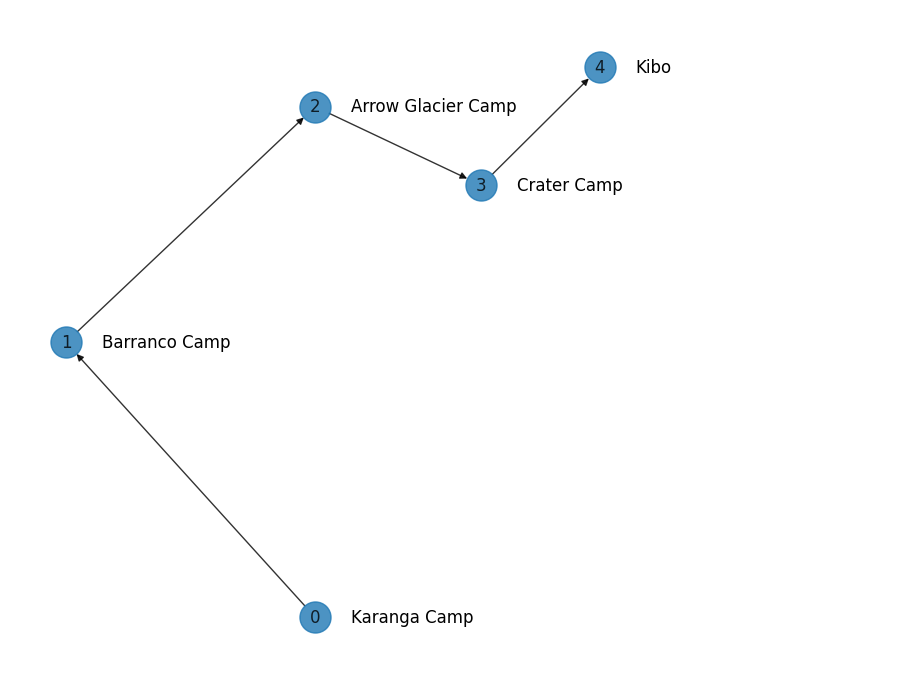

[ 0.23853619  0.66553143 -0.38612392 -0.16094398  0.45830685  0.59270993
  0.49878778  0.69798089]


In [226]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute()#initial_state)

# measure the output of the circuit and obtain results
nshots= 4000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
print(ordered_freq_counter)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(qaoa_solution) # QAOA solution is a binary string containing the solution 
print(final_parameters)

In [227]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.1
nqubits = (G.number_of_nodes()-3) ** 2

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.matrix)
H0_dense = Hamiltonian(nqubits, H0.matrix)

# define the scheduler
def s(t): return t

T = 80

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

[Qibo 0.1.13|WARNING|2023-05-07 10:52:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-05-07 10:52:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


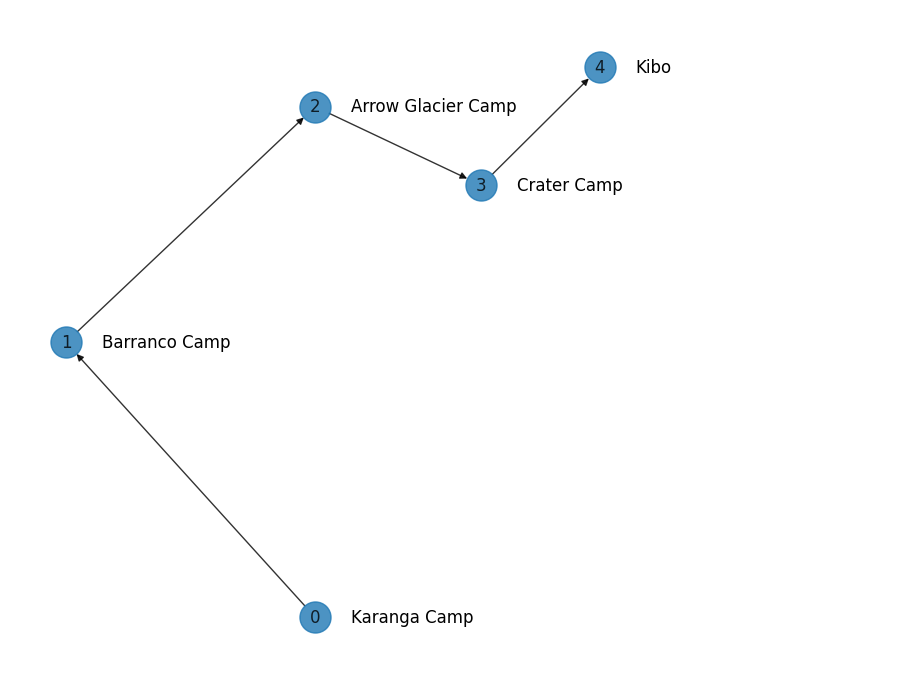

In [228]:
# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

display_solution(adiabatic_solution) # adiabatic solution is a binary string containing the solution

In [229]:
solution_array = np.argsort(np.abs(adiabatic_quantum_state) ** 2)[-20:]
print((np.abs(adiabatic_quantum_state) ** 2)[solution_dec])
for i in solution_array:
    print("{0:0{bits}b}".format(i, bits=nqubits)," ", (np.abs(adiabatic_quantum_state) ** 2)[i])

0.9919870646607557
1110   2.7115228872054354e-12
1111   7.61120032825407e-12
0111   1.6455883978599758e-11
1101   1.9733025355865418e-08
1100   3.182986333168804e-08
1011   8.454607428234309e-08
0101   3.353499702395789e-07
1010   1.4262833483917419e-06
0100   2.925116360245819e-06
0011   4.218868741414926e-06
0000   4.66191457887751e-06
0110   3.4969601029248035e-05
0001   4.832555645530398e-05
0010   0.00011682180487278248
1000   0.0077991147081429586
1001   0.9919870646607557


In [230]:

one_array=np.array([0,1])
zero_array=np.array([1,0])
print(H1.ground_state())
exp_ground_state = one_array
exp_ground_state = np.kron(exp_ground_state,zero_array)
exp_ground_state = np.kron(exp_ground_state,zero_array)
exp_ground_state = np.kron(exp_ground_state,one_array)
print(exp_ground_state)


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
